# Small data and deep learning
This Pratical session proposes to study several techniques for improving challenging context, in which few data and resources are available.

# Introduction
Assume we are in a context where few "gold" labeled data are available for training, say $\mathcal{X}_{\text{train}}\triangleq\{(x_n,y_n)\}_{n\leq N_{\text{train}}}$, where $N_{\text{train}}$ is small. A large test set $\mathcal{X}_{\text{test}}$ is available. A large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question:

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset)

In your final report, please keep the logs of each training procedure you used. We will only run this jupyter if we have some doubts on your implementation. 

__The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.__


You can use https://colab.research.google.com/ to run your experiments.

In [1]:
import os

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm

DATA_FOLDER = "."

device = torch.device("cuda" if torch.cuda.is_available else "cpu")
device

device(type='cuda')

## Training set creation
__Question 1 (2 points):__ Propose a dataloader or modify the file located at https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py in order to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set. 

In [2]:
class SubDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = list(indices)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]

    def __repr__(self):
        upper_repr = repr(self.dataset)
        upper_repr = "\n    ".join(upper_repr.split("\n"))
        return f"SubDataset of length {len(self)} from\n    {upper_repr}"


test = True
if test:
    X_train = datasets.CIFAR10(root=DATA_FOLDER, train=True, download=True)

    X = SubDataset(X_train, range(100, len(X_train)))
    X_train = SubDataset(X_train, range(100))
    print(X_train, X, sep="\n")
    del X_train, X

Files already downloaded and verified
SubDataset of length 100 from
    Dataset CIFAR10
        Number of datapoints: 50000
        Root location: .
        Split: Train
SubDataset of length 49900 from
    Dataset CIFAR10
        Number of datapoints: 50000
        Root location: .
        Split: Train


In [ ]:
from functools import reduce

def f(d, elt):
    c = d.get(elt, 0)
    d[elt] = c + 1
    return d

d = reduce(f, map(lambda x: x[1], list(X_train)), {})
sorted(d.items())

This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. The remaining samples correspond to $\mathcal{X}$. The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2 (1.5 points):__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

It's hard to stop the learning based on a validation set.

# Raw approach: the baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate schedule, i.e. how to decrease the learning rate as a function of the number of epochs. A possible schedule is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the laerning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper: http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. Obviously, it is a different context for those researchers who had access to GPUs.

## ResNet architectures

__Question 3 (4 points):__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint:* You can re-use the following code: https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

In [3]:
## DATA ##

cifar_train = datasets.CIFAR10(root=DATA_FOLDER, train=True, transform=transforms.ToTensor())

mean = torch.zeros(3)
std = torch.zeros(3)
for img, _ in cifar_train:
    mean += img.mean(dim=[1, 2])
    std += img.std(dim=[1, 2])
mean /= len(cifar_train)
std /= len(cifar_train)

In [4]:
# No data augmentation

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transform = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

X_train = torchvision.datasets.CIFAR10(root=DATA_FOLDER, train=True, transform=train_transform, download=True)
X_train = SubDataset(X_train, range(100))
X_test = torchvision.datasets.CIFAR10(root=DATA_FOLDER, train=False, transform=test_transform, download=True)

train_loader = torch.utils.data.DataLoader(X_train, 10, shuffle=True)
test_loader = torch.utils.data.DataLoader(X_test, 256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Loss / accuracy
criterion = nn.CrossEntropyLoss()

def accuracy(prediction, target):
    prediction = prediction.argmax(dim=1)
    return (prediction == target).sum() / len(target)

In [6]:
## MODEL ##
# Code from pytorch-cifar github (https://github.com/kuangliu/pytorch-cifar)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

model = ResNet18()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
def train(model, dataloader, optimizer, criterion, device):
    total_loss = 0
    N = 0
    for i, (data, target) in enumerate(dataloader):
        data = data.to(device)
        target = target.to(device)

        prediction = model(data)
        loss = criterion(prediction, target)
        
        batch_size = data.shape[0]
        N += batch_size

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss * batch_size
    return total_loss / N

def validate(model, dataloader, criterion, device):
    with torch.no_grad():
        total_loss = 0
        N = 0
        for i, (data, target) in enumerate(dataloader):
            data = data.to(device)
            target = target.to(device)
            
            batch_size = data.shape[0]
            N += batch_size

            prediction = model(data)
            total_loss += criterion(prediction, target) * batch_size
    return total_loss / N

In [9]:
for i in range(10): # up to 23% (Even with more epochs)
    print(i, end="...", flush=True)
    loss = train(model, train_loader, optimizer, criterion, device).item()
    print(f"\r{i}: {loss:.4f}")

validate(model, train_loader, accuracy, device).item(), validate(model, test_loader, accuracy, device).item()

0: 2.8355
1: 2.4048
2: 1.9479
3: 1.6552
4: 1.4052
5: 1.2381
6: 1.0629
7: 0.9017
8: 1.2125
9: 0.9551


(0.7099999785423279, 0.22809998691082)

# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on: https://pytorch.org/docs/stable/torchvision/models.html.

__Question 4 (3 points):__ Pick a model from the list above, adapt it for CIFAR and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

In [10]:
transform = torchvision.transforms.Compose([
    transforms.Resize(224),  # Important to resize in order to be able to use pretrained convolutions
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

X_train = torchvision.datasets.CIFAR10(root=DATA_FOLDER, train=True, transform=transform, download=True)
X_train = SubDataset(X_train, range(100))
X_test = torchvision.datasets.CIFAR10(root=DATA_FOLDER, train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(X_train, 10, shuffle=True)
test_loader = torch.utils.data.DataLoader(X_test, 256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 10)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# Train only last fc layer

optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
# optimizer = torch.optim.Adam(
#     [{"params": model.layer4.parameters(), "lr": 0.0001}, {"params": model.fc.parameters(), "lr": 0.01}],
#     )


for i in range(20): # Up to 55 %
    print(i, end="...", flush=True)
    loss = train(model, train_loader, optimizer, criterion, device).item()
    print(f"\r{i}: {loss:.4f}")

validate(model, train_loader, accuracy, device).item(), validate(model, test_loader, accuracy, device).item()

0: 2.3207
1: 1.9636
2: 1.7445
3: 1.5425
4: 1.4172
5: 1.2150
6: 1.1329
7: 1.0485
8: 1.0012
9: 0.8833
10: 0.8115
11: 0.7767
12: 0.6308
13: 0.6391
14: 0.5653
15: 0.5215
16: 0.5308
17: 0.5095
18: 0.5269
19: 0.4266


(0.949999988079071, 0.5120999813079834)

In [15]:
# Retrain a bit all the network
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for i in range(10): # Up to 60 %
    print(i, end="...", flush=True)
    loss = train(model, train_loader, optimizer, criterion, device).item()
    print(f"\r{i}: {loss:.4f}")

validate(model, train_loader, accuracy, device).item(), validate(model, test_loader, accuracy, device).item()

0: 0.4735
1: 0.0757
2: 0.0426
3: 0.0246
4: 0.0110
5: 0.0081
6: 0.0083
7: 0.0059
8: 0.0194
9: 0.0044


(1.0, 0.589199960231781)

# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks. For now, we only consider linear transformations $\mathcal{T}$ of the inputs $x:\mathbb{S}^2\rightarrow\mathbb{R}$ where $\mathbb{S}$ is the support of an image, meaning that:

$$\forall u\in\mathbb{S}^2,\mathcal{T}(\lambda x+\mu y)(u)=\lambda \mathcal{T}(x)(u)+\mu \mathcal{T}(y)(u)\,.$$

For instance if an image had an infinite support, a translation $\mathcal{T}_a$ by $a$ would lead to:

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

Otherwise, one has to handle several boundary effects.

__Question 5 (1.5 points):__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

## Data augmentations

__Question 6 (3 points):__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.

In [51]:
fill_color = tuple(map(lambda x: int(255*x), mean))

augmented_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.RandomRotation(20, fill=fill_color)], 0.3),
    # transforms.RandomApply([transforms.GaussianBlur(35, 0.5)], 0.5),
#     transforms.RandomCrop(32, 4, padding_mode="reflect"),
#     transforms.RandomPerspective,
    transforms.RandomApply([transforms.RandomResizedCrop(32, scale=(0.6, 1.0))], 0.7),
    # transforms.GaussianBlur(7, 0.5),
    # transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    # transforms.RandomApply([transforms.RandomErasing(1, scale=(0.01, 0.1))], 0.5),
])

base_transform = torchvision.transforms.Compose([
    # transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

X_train = torchvision.datasets.CIFAR10(root=DATA_FOLDER, train=True, transform=augmented_transform)
X_train = SubDataset(X_train, range(100))
X_test = torchvision.datasets.CIFAR10(root=DATA_FOLDER, train=False, transform=base_transform)
train_loader = torch.utils.data.DataLoader(X_train, 10, shuffle=True)
test_loader = torch.utils.data.DataLoader(X_test, 256, shuffle=False)

In [24]:
X = torchvision.datasets.CIFAR10(root=DATA_FOLDER, train=True, transform=base_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


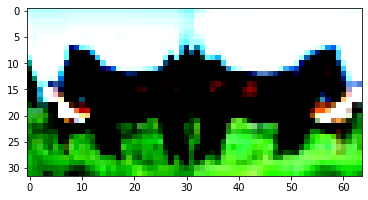

In [48]:
# Can be used to visualized transforms. Better without the normalize transformation

i = 12
img_base = X[i][0]
img_aug = X_train[i][0]

plt.imshow(torch.cat((img_base, img_aug), dim=2).permute(1, 2, 0))
plt.show()

In [63]:
model = ResNet18()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [64]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

for i in range(50): # Up to 28 %
    print(i, end="...", flush=True)
    loss = train(model, train_loader, optimizer, criterion, device).item()
    print(f"\r{i}: {loss:.4f}")

validate(model, train_loader, accuracy, device).item(), validate(model, test_loader, accuracy, device).item()

0: 2.7496
1: 2.3637
2: 2.2251
3: 2.0085
4: 1.9373
5: 1.7671
6: 1.7133
7: 1.7461
8: 1.6653
9: 1.6426
10: 1.5069
11: 1.5528
12: 1.4958
13: 1.3727
14: 1.2754
15: 1.2313
16: 1.4386
17: 1.2862
18: 1.3034
19: 1.1444
20: 1.0872
21: 1.1194
22: 1.1152
23: 1.0849
24: 0.9297
25: 0.8954
26: 0.7377
27: 0.9043
28: 0.7181
29: 0.7432
30: 0.9049
31: 0.8038
32: 0.8246
33: 0.8738
34: 0.8104
35: 0.6183
36: 0.6318
37: 0.5546
38: 0.7901
39: 0.6723
40: 0.7467
41: 0.6669
42: 0.5169
43: 0.6335
44: 0.6487
45: 0.5401
46: 0.5990
47: 0.5506
48: 0.5558
49: 0.4641


(0.8299999833106995, 0.2775999903678894)

# Conclusions

__Question 7 (5 points):__ Write a short report explaining the pros and the cons of each methods that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

# Weak supervision

__Bonus \[open\] question (up to 3 points):__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.

In [ ]:
class cat_dataloader():
    """Class to concatenate multiple dataloaders"""

    def __init__(self, dataloaders):
        self.dataloaders = dataloaders
        len(self.dataloaders)

    def __iter__(self):
        self.loader_iter = []
        for data_loader in self.dataloaders:
            self.loader_iter.append(iter(data_loader))
        return self

    def __next__(self):
        out = []
        for data_iter in self.loader_iter:
            out.append(next(data_iter)) # may raise StopIteration
        return tuple(out)


ssl_loader= cat_dataloader([train_loader,test_loader])


In [ ]:
def train(model, dataloader, optimizer, criterion, device):
    total_loss = 0
    N = 0
    for i, (data, target) in enumerate(dataloader):
        data = data.to(device)
        target = target.to(device)

        prediction = model(data)
        loss = criterion(prediction, target)
        
        batch_size = data.shape[0]
        N += batch_size

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss * batch_size
    return total_loss / N